In [1]:
import pandas as pd
from datetime import datetime
import shapefile
import csv
import numpy as np
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import pickle
import zipfile as zpf

import time
from pylab import *

/Users/cuichenxi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Define helper functions

In [2]:
os.getcwd()

'/Users/cuichenxi/Applied Data Science'

In [3]:
path = os.getcwd()+'/Science/BikeData'

In [4]:

def getCitiBikeCSV(datestring):
    '''The function downloads a CSV file into the PUIDATA directory from the Citibike database for the given datestring
    Author: vys217 lifting code from 
    https://github.com/fedhere/PUI2016_fb55/blob/master/HW3_fb55/citibikes_gender.ipynb
    '''
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(path + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + path):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(path + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip") 
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mkdir " + path) ##you have to make a new file directory first 
                os.system("mv " + datestring + "-citibike-tripdata.zip " + path)
            ### unzip the csv 
            os.system("unzip " + path + "/" + datestring + "-citibike-tripdata.zip -d " + path)
            print("unzip " + path + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + path)
    ### One final check:
    if not os.path.isfile(path + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [5]:

def make_age(text):
    """Given a year in string format, return current age"""
    
    return 2016 - datetime.strptime(text, '%Y').year

# for reading csv: converters = {13:make_age}, but NA values mess it up

def explore(x, dataset_name):
    """Print specified summary information of given dataset x"""
    
    d = {}
    d['length'] = len(x)
    d['unique neighborhoods'] = len(x['neighborhood_x'].value_counts())
    d['unique stations'] = len(x['start station id'].value_counts())
    d['percent of start stations in Manhattan'] = "{0:.3%}".format(x['borough_x'].value_counts()[0]/len(x))
    d['percent of end stations in Manhattan'] = "{0:.3%}".format(x['borough_y'].value_counts()[0]/len(x))
    d['percent of trips under 45min'] = "{0:.3%}".format(x.over_45.value_counts()[0]/len(x))
    d['most popular start station'] = "{0}".format(x['neighborhood_x'].value_counts().reset_index().ix[0].tolist())
    d['least popular start station'] = "{0}".format(x['neighborhood_x'].value_counts().reset_index().ix[36].tolist())
    d['unique bikes'] = len(x.bikeid.unique())
    d['percent subscribers'] = "{0:.3%}".format(x.usertype.value_counts()[0]/len(x))
    
    if x['birth year'].isnull().any() == False:
        d['mean birth year'] = "{0:.0f}".format(x['birth year'].mean())
    
    print "\nSummary of {0} dataset".format(dataset_name), pd.DataFrame(d.items())

### Read files to dataframes

### Create one dataframe of multiple months

In [6]:
# os.system("curl -O https://s3.amazonaws.com/tripdata/201608-citibike-tripdata.zip")

In [7]:
os.system("unzip " + os.getcwd() + "/" + '201608'+ "-citibike-tripdata.zip -d "+ os.getcwd())

2304

In [8]:
data_hoods = pd.read_csv('nyc_neighborhoods.csv') # merged database from CartoDB
docks = data_hoods[['id','docks','neighborhood','borough']] # create sub dataframe of dock capacity per id

# df_1 = pd.read_csv('citibike_jan.csv') # merged database of neighborhoods and citibike data
# df_2 = pd.read_csv('citibike_feb.csv') # merged database of neighborhoods and citibike data
# df_12 = pd.read_csv('citibike_dec.csv') # merged database of neighborhoods and citibike data

In [9]:
data_hoods.head()

,the_geom,id,latitude,statuskey,longitude,address,docks,teststatio,service,stationnam,availdocks,availbikes,lastcomm,loc,address2,created_at,updated_at,neighborhood,borough,cartodb_id
0,0101000020E6100000381D615AC67E52C0E981C450455C...,150,40.720874,1,-73.980858,E 2 St & Avenue C,31,False,In Service,E 2 St & Avenue C,19,11,null,NaN,NaN,2015-07-27 20:11:50.798449+00,2015-07-27 20:11:50.798449+00,East Village,Manhattan,15
1,0101000020E6100000ABD759452D7F52C01FEECD8C3C5D...,236,40.728419,1,-73.987140,St Marks Pl & 2 Ave,36,False,In Service,St Marks Pl & 2 Ave,6,28,null,NaN,NaN,2015-07-27 20:11:50.798449+00,2015-07-27 20:11:50.798449+00,East Village,Manhattan,39
2,0101000020E6100000E3797175267F52C0EBB61CDF7F5D...,237,40.730473,1,-73.986724,E 11 St & 2 Ave,39,False,In Service,E 11 St & 2 Ave,1,38,null,NaN,NaN,2015-07-27 20:11:50.798449+00,2015-07-27 20:11:50.798449+00,East Village,Manhattan,40
3,0101000020E6100000C73D3FA2727E52C05677D564A15C...,266,40.723684,1,-73.975748,Avenue D & E 8 St,24,False,In Service,Avenue D & E 8 St,21,3,null,NaN,NaN,2015-07-27 20:11:50.798449+00,2015-07-27 20:11:50.798449+00,East Village,Manhattan,65
4,0101000020E610000069EEA348687F52C061426252055E...,285,40.734546,1,-73.990741,Broadway & E 14 St,47,False,In Service,Broadway & E 14 St,9,37,null,NaN,NaN,2015-07-27 20:11:50.798449+00,2015-07-27 20:11:50.798449+00,East Village,Manhattan,79


In [10]:
docks.head()

,id,docks,neighborhood,borough
0,150,31,East Village,Manhattan
1,236,36,East Village,Manhattan
2,237,39,East Village,Manhattan
3,266,24,East Village,Manhattan
4,285,47,East Village,Manhattan


In [11]:
full_df = pd.DataFrame()
year_range = ['201608']
for year in year_range:
    print year
    fname = year+ "-citibike-tripdata.zip"

#     getCitiBikeCSV(year)
    zf = zpf.ZipFile(path + "/" + year+ "-citibike-tripdata.zip")
    temp = pd.read_csv(zf.open(fname.replace('.zip','.csv')))
    full_df = full_df.append(temp) 

201608


In [12]:
full_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,288,8/1/2016 00:01:22,8/1/2016 00:06:11,302,Avenue D & E 3 St,40.720828,-73.977932,428,E 3 St & 1 Ave,40.724677,-73.987834,16920,Subscriber,1961.0,1
1,457,8/1/2016 00:01:43,8/1/2016 00:09:21,285,Broadway & E 14 St,40.734546,-73.990741,432,E 7 St & Avenue A,40.726218,-73.983799,20084,Subscriber,1989.0,2
2,278,8/1/2016 00:02:10,8/1/2016 00:06:49,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3096,Union Ave & N 12 St,40.719240,-73.952420,18380,Subscriber,1971.0,1
3,862,8/1/2016 00:02:13,8/1/2016 00:16:36,280,E 10 St & 5 Ave,40.733320,-73.995101,280,E 10 St & 5 Ave,40.733320,-73.995101,24101,Subscriber,1995.0,1
4,407,8/1/2016 00:02:21,8/1/2016 00:09:09,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,428,E 3 St & 1 Ave,40.724677,-73.987834,18949,Subscriber,1993.0,1


### Add fields

In [13]:
full_df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [14]:
# Prepare datasets for analysis (add variables, merge dock info)

# Create continuous time variable in min, from 0 (12am) to 1439 (11:59pm)
full_df['starttime_time'] = full_df['starttime'].map(lambda x: time.strptime(x, "%m/%d/%Y %H:%M:%S").tm_hour*60 + 
                                      time.strptime(x, "%m/%d/%Y %H:%M:%S").tm_min)

# create 'over_45' min column (1 if yes, 0 if no) -- for exploration purposes
full_df['over_45'] = full_df.tripduration.map(lambda x: 1 if x>2700 else 0)

week   = ['Monday', 'Tuesday', 'Wednesday', 
              'Thursday', 'Friday', 'Saturday','Sunday']

# Column for day of the week (0-6)
full_df['day_start']=full_df['starttime'].map(lambda x: week[datetime.datetime.strptime(x, "%m/%d/%Y %H:%M:%S").weekday()])

# merge!
t = pd.merge(full_df,docks,how='left',left_on='start station id',right_on='id')
full_df = pd.merge(t,docks,how='left',left_on='end station id',right_on='id')

In [15]:
full_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,over_45,day_start,id_x,docks_x,neighborhood_x,borough_x,id_y,docks_y,neighborhood_y,borough_y
0,288,8/1/2016 00:01:22,8/1/2016 00:06:11,302,Avenue D & E 3 St,40.720828,-73.977932,428,E 3 St & 1 Ave,40.724677,...,0,Monday,302.0,23.0,East Village,Manhattan,428.0,31.0,East Village,Manhattan
1,457,8/1/2016 00:01:43,8/1/2016 00:09:21,285,Broadway & E 14 St,40.734546,-73.990741,432,E 7 St & Avenue A,40.726218,...,0,Monday,285.0,47.0,East Village,Manhattan,432.0,31.0,East Village,Manhattan
2,278,8/1/2016 00:02:10,8/1/2016 00:06:49,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3096,Union Ave & N 12 St,40.719240,...,0,Monday,539.0,31.0,Williamsburg,Brooklyn,NaN,NaN,NaN,NaN
3,862,8/1/2016 00:02:13,8/1/2016 00:16:36,280,E 10 St & 5 Ave,40.733320,-73.995101,280,E 10 St & 5 Ave,40.733320,...,0,Monday,280.0,31.0,Greenwich Village,Manhattan,280.0,31.0,Greenwich Village,Manhattan
4,407,8/1/2016 00:02:21,8/1/2016 00:09:09,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,428,E 3 St & 1 Ave,40.724677,...,0,Monday,161.0,35.0,Greenwich Village,Manhattan,428.0,31.0,East Village,Manhattan


In [16]:
full_df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'starttime_time', u'over_45',
       u'day_start', u'id_x', u'docks_x', u'neighborhood_x', u'borough_x',
       u'id_y', u'docks_y', u'neighborhood_y', u'borough_y'],
      dtype='object')

### Dump dataframe into pickle file

In [17]:
with open('full_data.pkl','wb') as f:
    pickle.dump(full_df,f)

### Explore the data

In [18]:
# Subset for subscribers, and trips over 1hr

df_sub = full_df[(full_df['birth year']>1915.0) & (full_df['usertype']=='Subscriber') 
                 & (full_df['gender']!=0) & (full_df['tripduration']<=3600)] 

In [19]:
df_sub.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'starttime_time', u'over_45',
       u'day_start', u'id_x', u'docks_x', u'neighborhood_x', u'borough_x',
       u'id_y', u'docks_y', u'neighborhood_y', u'borough_y'],
      dtype='object')

In [20]:
df_sub.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,over_45,day_start,id_x,docks_x,neighborhood_x,borough_x,id_y,docks_y,neighborhood_y,borough_y
0,288,8/1/2016 00:01:22,8/1/2016 00:06:11,302,Avenue D & E 3 St,40.720828,-73.977932,428,E 3 St & 1 Ave,40.724677,...,0,Monday,302.0,23.0,East Village,Manhattan,428.0,31.0,East Village,Manhattan
1,457,8/1/2016 00:01:43,8/1/2016 00:09:21,285,Broadway & E 14 St,40.734546,-73.990741,432,E 7 St & Avenue A,40.726218,...,0,Monday,285.0,47.0,East Village,Manhattan,432.0,31.0,East Village,Manhattan
2,278,8/1/2016 00:02:10,8/1/2016 00:06:49,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3096,Union Ave & N 12 St,40.719240,...,0,Monday,539.0,31.0,Williamsburg,Brooklyn,NaN,NaN,NaN,NaN
3,862,8/1/2016 00:02:13,8/1/2016 00:16:36,280,E 10 St & 5 Ave,40.733320,-73.995101,280,E 10 St & 5 Ave,40.733320,...,0,Monday,280.0,31.0,Greenwich Village,Manhattan,280.0,31.0,Greenwich Village,Manhattan
4,407,8/1/2016 00:02:21,8/1/2016 00:09:09,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,428,E 3 St & 1 Ave,40.724677,...,0,Monday,161.0,35.0,Greenwich Village,Manhattan,428.0,31.0,East Village,Manhattan


In [21]:
explore(full_df,'full')
explore(df_sub,'sub')


Summary of full dataset                                         0                          1
0            percent of trips under 45min                    98.057%
1              most popular start station        ['Midtown', 158441]
2                         unique stations                        574
3                                  length                    1557663
4    percent of end stations in Manhattan                    70.643%
5                            unique bikes                       9284
6             least popular start station  ['Upper East Side', 1039]
7  percent of start stations in Manhattan                    70.183%
8                     percent subscribers                    85.989%
9                    unique neighborhoods                         37

Summary of sub dataset                                          0                         1
0             percent of trips under 45min                   99.419%
1               most popular start station       ['Mid

### Distribution of birth years

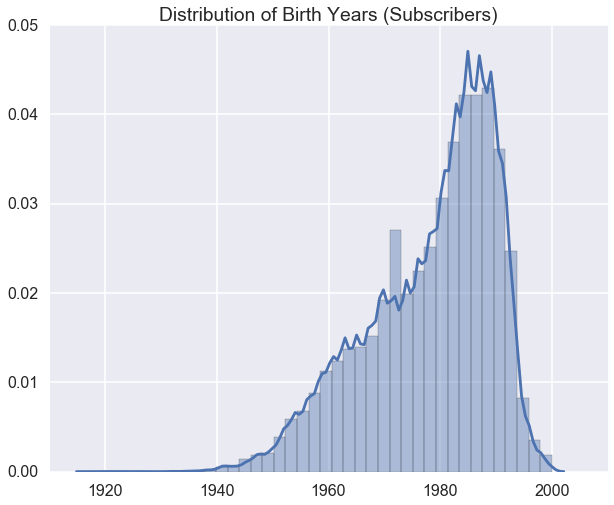

In [22]:
plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_sub['birth year'].values,bins=40)
plt.title("Distribution of Birth Years (Subscribers)")
savefig('age_dist.png')

### Distribution of dock capacities over 329 stations

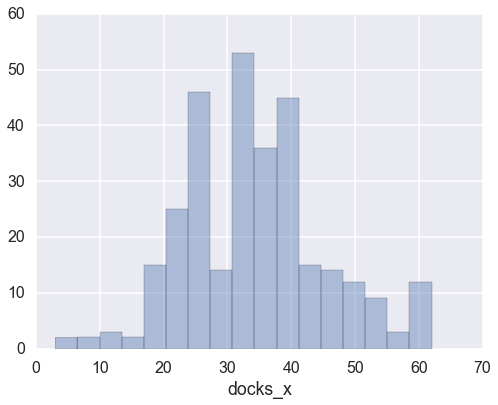

In [23]:
g = df_sub.groupby('id_x')

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(g.docks_x.mean(),kde=False)

In [24]:
print "Stations with highest dock capacity"
print data_hoods.sort('docks',ascending=False)[['id','docks','address']].head()
print "\nStations with lowest dock capacity"
print data_hoods.sort('docks',ascending=False)[['id','docks','address']].tail()

Stations with highest dock capacity
      id  docks                            address
170  521     67                    8 Ave & W 31 St
37    83     62      Atlantic Ave & Fort Greene Pl
276  519     61                  Pershing Square N
64   281     59  Grand Army Plaza & Central Park S
205  427     59                           State St

Stations with lowest dock capacity
      id  docks                        address
328  532     10                S 5 Pl & S 4 St
92   524      7                W 43 St & 6 Ave
25   253      7                W 13 St & 5 Ave
211  297      3                E 15 St & 3 Ave
186  321      3  Cadman Plaza E & Red Cross Pl


/Users/cuichenxi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/Users/cuichenxi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Distribution of gender for all rides

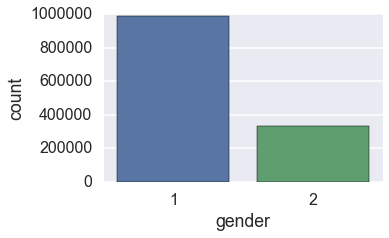

In [25]:
plt.figure(figsize=(5, 3))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.countplot(df_sub.gender)

### Number of trips by time of day (starttime_time in minutes from 00:00)

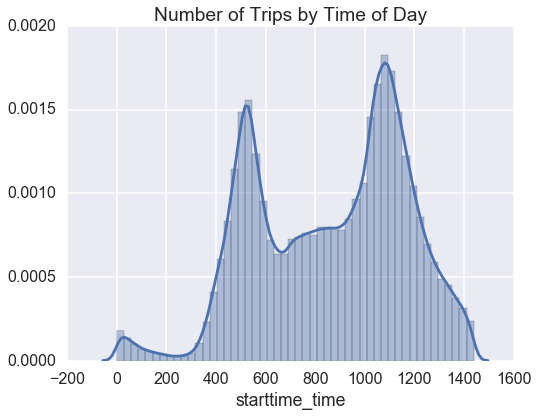

In [26]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_sub.starttime_time)
plt.title("Number of Trips by Time of Day")
savefig('trips_by_hour.png')

### Mean trip duration per hour

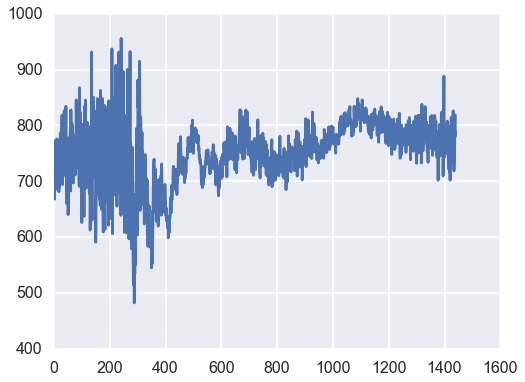

In [27]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
a = df_sub.groupby('starttime_time')
plt.plot(a.tripduration.mean())

### Trip duration distribution

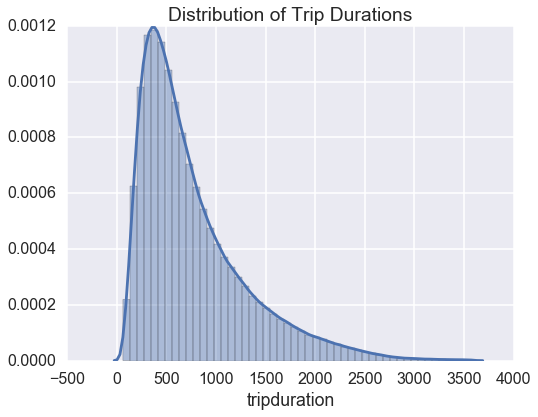

In [28]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_sub.tripduration)
plt.title("Distribution of Trip Durations")
savefig('trip_dist.png')

### Average trip duration from neighborhoods

In [29]:
a = df_sub.groupby(df_sub['neighborhood_x'])
df_sub = df_sub[pd.notnull(df_sub['neighborhood_x'])]

In [30]:

df_sub['neighborhood_x'].unique()

array(['East Village', 'Williamsburg', 'Greenwich Village', 'Chelsea',
       'Financial District', 'West Village', 'Brooklyn Heights',
       'Vinegar Hill', "Hell's Kitchen", 'Midtown', 'NoHo',
       'Lower East Side', 'Nolita', 'Bedford-Stuyvesant', 'Tribeca',
       'Kips Bay', 'Downtown Brooklyn', 'Murray Hill', 'Battery Park City',
       'Stuyvesant Town', 'Gramercy', 'SoHo', 'Chinatown', 'Park Slope',
       'Theater District', 'Flatiron District', 'Fort Greene',
       'Two Bridges', 'Civic Center', 'Clinton Hill', 'Central Park',
       'DUMBO', 'Upper West Side', 'Boerum Hill', 'Upper East Side',
       'Navy Yard', 'Columbia St'], dtype=object)

In [31]:
# for i in df_sub['neighborhood_x'].unique():
#     print i
#     print a.get_group(i).tripduration.mean()

In [32]:
meantime = []
for i in df_sub['neighborhood_x'].unique():
    meantime.append(a.get_group(i).tripduration.mean())

In [33]:
meantime = np.array(meantime)

In [34]:
colum=['meantime']
timenb = pd.DataFrame(index=df_sub['neighborhood_x'].unique(),columns=colum)

In [35]:
timenb['meantime'] = meantime

In [36]:
# a = df_sub.groupby(df_sub['neighborhood_x'])

# a.get_group('East Village').tripduration.mean()

In [37]:
# timenb

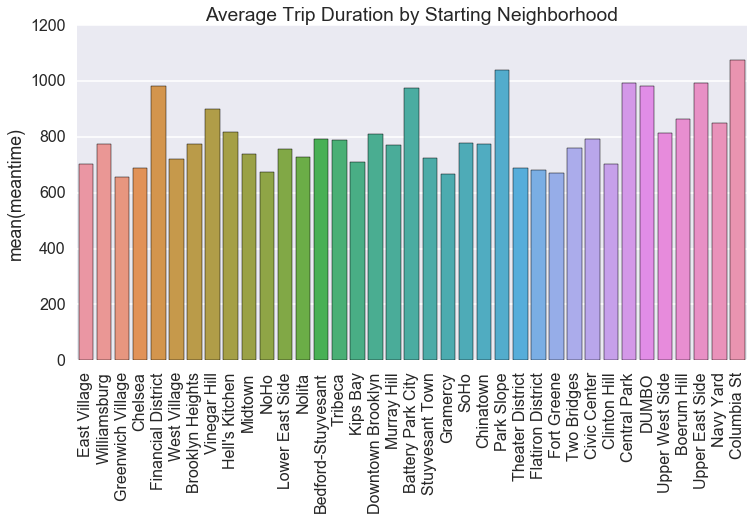

In [38]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
# a = df_sub.groupby(df_sub['neighborhood_x'])
# names = a.tripduration.mean().reset_index()['neighborhood_x']
# y = a.tripduration.mean().reset_index()['tripduration']

sns.barplot(x = timenb.index, y = 'meantime', data = timenb, estimator = np.mean)
plt.xticks(rotation='90')
plt.title("Average Trip Duration by Starting Neighborhood")
#plt.bar(range(len(names)),y)
#plt.xticks(range(len(names)), names, rotation='90')
plt.show()
savefig('avg_trip_neighborhood.png')

### Average trip duration by borough start station

In [39]:
b = df_sub.groupby(df_sub['borough_x'])

In [40]:
meantime = []
for i in df_sub['borough_x'].unique():
    meantime.append(b.get_group(i).tripduration.mean())
meantime = np.array(meantime)

In [41]:
colum=['meantime']
timeboro = pd.DataFrame(index=df_sub['borough_x'].unique(),columns=colum)

In [42]:
timeboro['meantime'] = meantime


In [43]:
timeboro.head

<bound method DataFrame.head of              meantime
Manhattan  749.005129
Brooklyn   783.930704>

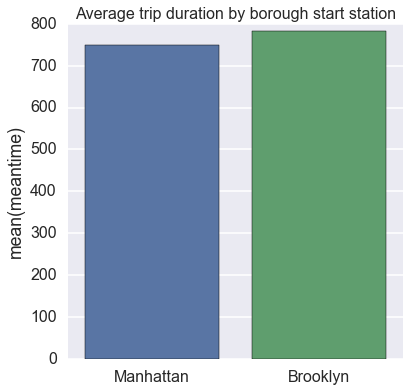

In [44]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
#a = df_sub.groupby('b1')
#names = a.tripduration.mean().reset_index()['b1']
#y = a.tripduration.mean().reset_index()['tripduration']

sns.barplot(x = timeboro.index, y = 'meantime', data = timeboro, estimator = np.mean)

#plt.bar(range(len(names)),y)
#plt.xticks(range(len(names)), names)
plt.title('Average trip duration by borough start station',fontsize = 16)
plt.show()

In [45]:
# list most frequented destination station given start station
g = df_sub.groupby('neighborhood_x')
s = []
for n in df_sub['neighborhood_x'].unique():
    print n,g.neighborhood_y.value_counts()
#     .xs(n).reset_index().ix[0].values
    s.append(g.neighborhood_y.value_counts())
#              .xs(n).reset_index().ix[0].values)

East Village neighborhood_x     neighborhood_y    
Battery Park City  Battery Park City     4140
                   Tribeca               3701
                   Financial District    3672
                   Chelsea               3221
                   West Village          3195
                   Hell's Kitchen        2104
                   SoHo                  1487
                   Greenwich Village      796
                   East Village           792
                   Midtown                716
                   Lower East Side        645
                   Civic Center           605
                   Chinatown              409
                   Nolita                 258
                   Murray Hill            243
                   Flatiron District      221
                   Stuyvesant Town        207
                   Gramercy               191
                   Vinegar Hill           181
                   Kips Bay               171
                   Theater Di

In [46]:
g

#####  plot top dest stations (not telling)

plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
sns.set_context(context="poster")

g = pd.DataFrame(s).groupby(0)
d = g.sum().reset_index().sort(1,ascending=False)
n = d[0].values
ct = d[1].values
#plt.bar(range(len(n)),ct,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("dark", 10))
#plt.xticks(range(len(n)), n, rotation='90')

### Create time passed between trips, dataframe

In [47]:
df_bikeid = full_df.copy(deep=True) # make copy of original data

In [48]:
# convert time columns into datetime objects

df_bikeid['starttime'] = df_bikeid['starttime'].map(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y %H:%M:%S"))
df_bikeid['stoptime'] = df_bikeid['stoptime'].map(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y %H:%M:%S"))

In [49]:
# sort data by bikeid, then chronologically

df2_bikeid = df_bikeid.sort(columns = ['bikeid','starttime'],ascending=[0, 1]) # sort by bike, then time

/Users/cuichenxi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [50]:
df2_bikeid.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,over_45,day_start,id_x,docks_x,neighborhood_x,borough_x,id_y,docks_y,neighborhood_y,borough_y
1493007,739,2016-08-30 19:49:58,2016-08-30 20:02:17,3298,Warren St & Court St,40.686371,-73.993833,416,Cumberland St & Lafayette Ave,40.687534,...,0,Tuesday,NaN,NaN,NaN,NaN,416.0,31.0,Fort Greene,Brooklyn
1495826,146,2016-08-30 20:47:38,2016-08-30 20:50:04,416,Cumberland St & Lafayette Ave,40.687534,-73.972652,258,DeKalb Ave & Vanderbilt Ave,40.689407,...,0,Tuesday,416.0,31.0,Fort Greene,Brooklyn,258.0,23.0,Clinton Hill,Brooklyn
1496177,483,2016-08-30 20:56:57,2016-08-30 21:05:01,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,3057,Kosciuszko St & Tompkins Ave,40.691283,...,0,Tuesday,258.0,23.0,Clinton Hill,Brooklyn,NaN,NaN,NaN,NaN
1508758,308,2016-08-31 08:29:36,2016-08-31 08:34:44,3057,Kosciuszko St & Tompkins Ave,40.691283,-73.945242,3064,Myrtle Ave & Lewis Ave,40.696820,...,0,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1516093,1927,2016-08-31 10:04:37,2016-08-31 10:36:44,3064,Myrtle Ave & Lewis Ave,40.696820,-73.937569,444,Broadway & W 24 St,40.742354,...,0,Wednesday,NaN,NaN,NaN,NaN,444.0,52.0,Flatiron District,Manhattan


In [51]:
# shift data down to append later on

t = df2_bikeid.shift(1)
t = t[['stoptime','end station id','bikeid']]
t.columns = [x+"_" for x in t.columns]

In [52]:
# append data

df_bikeid = pd.concat((t,df2_bikeid),1)

# keep rows where bikeids are equal

df_bikeid = df_bikeid[df_bikeid['bikeid_']==df_bikeid['bikeid']]

In [53]:
# create column of time lapsed
df_bikeid['time_lapsed'] = df_bikeid.apply(lambda row: (row['starttime'] 
                                                        - row['stoptime_']), axis=1)
print 1

1


In [54]:
# Boolean variable to measure equality of end and start stations
df_bikeid['same_station'] = df_bikeid.apply(lambda row: True if 
                    row['end station id_'] == row['start station id'] else False, axis=1)

In [55]:
df_bikeid.head()

,stoptime_,end station id_,bikeid_,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,...,id_x,docks_x,neighborhood_x,borough_x,id_y,docks_y,neighborhood_y,borough_y,time_lapsed,same_station
1495826,2016-08-30 20:02:17,416.0,26969.0,146,2016-08-30 20:47:38,2016-08-30 20:50:04,416,Cumberland St & Lafayette Ave,40.687534,-73.972652,...,416.0,31.0,Fort Greene,Brooklyn,258.0,23.0,Clinton Hill,Brooklyn,00:45:21,True
1496177,2016-08-30 20:50:04,258.0,26969.0,483,2016-08-30 20:56:57,2016-08-30 21:05:01,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,...,258.0,23.0,Clinton Hill,Brooklyn,NaN,NaN,NaN,NaN,00:06:53,True
1508758,2016-08-30 21:05:01,3057.0,26969.0,308,2016-08-31 08:29:36,2016-08-31 08:34:44,3057,Kosciuszko St & Tompkins Ave,40.691283,-73.945242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:24:35,True
1516093,2016-08-31 08:34:44,3064.0,26969.0,1927,2016-08-31 10:04:37,2016-08-31 10:36:44,3064,Myrtle Ave & Lewis Ave,40.696820,-73.937569,...,NaN,NaN,NaN,NaN,444.0,52.0,Flatiron District,Manhattan,01:29:53,True
1520368,2016-08-31 10:36:44,444.0,26969.0,1088,2016-08-31 12:04:36,2016-08-31 12:22:45,444,Broadway & W 24 St,40.742354,-73.989151,...,444.0,52.0,Flatiron District,Manhattan,150.0,31.0,East Village,Manhattan,01:27:52,True


In [57]:
df_bikeid.columns

Index([u'stoptime_', u'end station id_', u'bikeid_', u'tripduration',
       u'starttime', u'stoptime', u'start station id', u'start station name',
       u'start station latitude', u'start station longitude',
       u'end station id', u'end station name', u'end station latitude',
       u'end station longitude', u'bikeid', u'usertype', u'birth year',
       u'gender', u'starttime_time', u'over_45', u'day_start', u'id_x',
       u'docks_x', u'neighborhood_x', u'borough_x', u'id_y', u'docks_y',
       u'neighborhood_y', u'borough_y', u'time_lapsed', u'same_station'],
      dtype='object')

In [62]:
t = df_bikeid.shift(1)
t = t[['stoptime','end station id','neighborhood_y','day_start','bikeid']]
t.columns = [x+"t" for x in t.columns]

# add a shifted-down version of the database to itself, to analyze rebalancing ratio
df_bikes = pd.concat((t,df_bikeid),1) 

In [63]:
df_bikes.head()

,stoptimet,end station idt,neighborhood_yt,day_startt,bikeidt,stoptime_,end station id_,bikeid_,tripduration,starttime,...,id_x,docks_x,neighborhood_x,borough_x,id_y,docks_y,neighborhood_y,borough_y,time_lapsed,same_station
1495826,NaT,NaN,NaN,NaN,NaN,2016-08-30 20:02:17,416.0,26969.0,146,2016-08-30 20:47:38,...,416.0,31.0,Fort Greene,Brooklyn,258.0,23.0,Clinton Hill,Brooklyn,00:45:21,True
1496177,2016-08-30 20:50:04,258.0,Clinton Hill,Tuesday,26969.0,2016-08-30 20:50:04,258.0,26969.0,483,2016-08-30 20:56:57,...,258.0,23.0,Clinton Hill,Brooklyn,NaN,NaN,NaN,NaN,00:06:53,True
1508758,2016-08-30 21:05:01,3057.0,NaN,Tuesday,26969.0,2016-08-30 21:05:01,3057.0,26969.0,308,2016-08-31 08:29:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:24:35,True
1516093,2016-08-31 08:34:44,3064.0,NaN,Wednesday,26969.0,2016-08-31 08:34:44,3064.0,26969.0,1927,2016-08-31 10:04:37,...,NaN,NaN,NaN,NaN,444.0,52.0,Flatiron District,Manhattan,01:29:53,True
1520368,2016-08-31 10:36:44,444.0,Flatiron District,Wednesday,26969.0,2016-08-31 10:36:44,444.0,26969.0,1088,2016-08-31 12:04:36,...,444.0,52.0,Flatiron District,Manhattan,150.0,31.0,East Village,Manhattan,01:27:52,True


In [64]:
df_bikes.columns

Index([u'stoptimet', u'end station idt', u'neighborhood_yt', u'day_startt',
       u'bikeidt', u'stoptime_', u'end station id_', u'bikeid_',
       u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'starttime_time', u'over_45',
       u'day_start', u'id_x', u'docks_x', u'neighborhood_x', u'borough_x',
       u'id_y', u'docks_y', u'neighborhood_y', u'borough_y', u'time_lapsed',
       u'same_station'],
      dtype='object')

In [ ]:
df_bikes = df_bikes[df_bikes['bikeid_']==df_bikeid['bikeid']]

# Create time lapse and same station column
df_bikes['time_lapsed'] = df_bikes.apply(lambda row: (row['starttime'] - row['stoptime_']), axis=1)
df_bikes['same_station'] = df_bikes.apply(lambda row: True if row['end station id_'] == row['start station id'] else False, axis=1)

# Remove buggy trips (where bike departs before it's been dropped off)
bad_bikes = df_bikes[df_bikes['time_lapsed']<0].bikeid.unique()
df_good_bikes = df_bikes[-df_bikes['bikeid'].isin(bad_bikes)]

### Various pickling of database versions and modeling results

In [ ]:
with open('bikeid_data_good.pkl','wb') as f:
    pickle.dump(df_good_bikes,f)
    
with open('model_results_1.pkl','r') as f:
    r_1 = pickle.load(f)
    
with open('bikeid_data_good.pkl','r') as f:
    df = pickle.load(f)

In [ ]:
df_sub = df_full[(df_full['birth_year']>1915.0) & (df_full['usertype']=='Subscriber') 
                 & (df_full['gender']!=0)& (df_full['tripduration']<=3600)]  

print len(df_full)
print len(df_sub)

In [ ]:
# convert cumulative trip duration variable into float for future analysis
df['cum_amt'] = df['cum_amt'].map(lambda f : float(f)) 

### Split data into features and response variable

In [ ]:
def assign_train_test(df_any, sub=True):
    '''Assign y and X. 
    Dummify categorical variables (neighborhood, weekday, gender).
    Standardize continuous variables.
    Returns train and test subsets'''
    
    # response variable is destination neighborhood
    
    # features depend on whether analysis on all data or subscriber data
    
    # Subscriber data, classification (includes information we would only know after the fact)
    if sub==True:
        y = df_any['n2']
        cols_n = ['tripduration','birth_year','starttime_time','docks_y'] # features to Standardize
        cols_c = ['n1','gender','day_start'] # categorical features
    
    # All data (subscribers and customers)
    elif sub==False:
        y = df_any['n2']
        cols_n = ['tripduration','starttime_time','docks_y'] # features to Standardize
        cols_c = ['n1','day_start','usertype'] # categorical features. include usertype as feature
    
    # Bikeid data (to predict rebalancing)
    elif sub=='bikes':
        y = df_any['same_station']
        cols_n = ['cum_amt']
        cols_c = ['n2_','day_start_']
    
    # Subscriber data, real prediction (excludes information we would only know after the fact)
    else:
        y = df_any['n2']
        cols_n = ['birth_year','starttime_time'] # features to Standardize
        cols_c = ['gender','day_start','n1']
    
    X = df_any[cols_n + cols_c]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    
    scaler = StandardScaler() # Standardize continuous variables
    scaler.fit(X_train[cols_n]) # Fit standardization rule to training data
        
    # continous variable treatment
    X_train_1 = pd.DataFrame(scaler.transform(X_train[cols_n]), columns=cols_n)
    X_test_1 = pd.DataFrame(scaler.transform(X_test[cols_n]), columns=cols_n)
    
    # categorical variables
    X_train_2 = pd.get_dummies(X_train[cols_c], columns = cols_c)
    X_test_2 = pd.get_dummies(X_test[cols_c], columns = cols_c)
    
    # bring 'em together
    X_train = pd.concat((X_train_1.reset_index(drop=True),X_train_2.reset_index(drop=True)),1)
    X_test = pd.concat((X_test_1.reset_index(drop=True),X_test_2.reset_index(drop=True)),1)
    
    return X_train, X_test, y_train, y_test